Source:
https://pytorch.org/tutorials/beginner/nn_tutorial.html

In [1]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

This dataset is in numpy array format, and has been stored using pickle, a python-specific format for serializing data

In [2]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

Each image is 28 x 28, and **is being stored as a flattened row** of length 784:

In [3]:
x_train.shape

(50000, 784)

In [4]:
y_train.shape

(50000,)

9


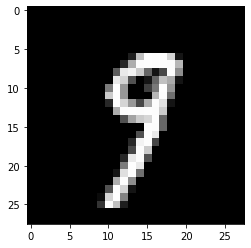

In [5]:
from matplotlib import pyplot
import numpy as np

example = 43
pyplot.imshow(x_train[example].reshape((28, 28)), cmap="gray")
print(y_train[example])

In [6]:
import torch

# convert to torch tensors:
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
    )

# `TensorDataset`

A tensor as a list of (x,y) pairs.

In [7]:
from torch.utils.data import TensorDataset

train_ds = TensorDataset(x_train, y_train)

In [8]:
len(train_ds) # number of examples

50000

In [9]:
len(train_ds[0]) # flat + label

2

In [10]:
train_ds[0][0].shape # flat

torch.Size([784])

In [11]:
train_ds[0][1].shape # label

torch.Size([])

# `DataLoader`
For **batching**. Very needed.

In [12]:
from torch.utils.data import DataLoader

bs = 64 # batch size
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

Notice that `shuffle=True` will shuffle the whole data at each epoch.

In [13]:
len(train_dl) # number of batches

782

In [14]:
# double check
import math
math.ceil(len(train_ds) / 64)

782

In [15]:
train_dl.batch_size

64

In [16]:
list(train_dl)[0] # first batch
# run this cell each time shows a different batch bcz of shuffle=True

[tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([2, 9, 7, 2, 9, 6, 3, 4, 8, 8, 0, 7, 1, 7, 2, 1, 6, 3, 1, 2, 5, 4, 1, 6,
         3, 8, 3, 8, 4, 2, 9, 9, 2, 7, 6, 9, 1, 2, 6, 0, 7, 1, 6, 2, 3, 8, 0, 4,
         6, 5, 6, 2, 9, 1, 4, 5, 9, 2, 3, 4, 1, 4, 7, 1])]

You can loop over `train_dl` like this:
```python
for epoch in range(epochs):
    
    for xb, yb in train_dl: # one batch at a time
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

```

# `model.train()`,  `model.eval()`

Layers like **dropout, batchnorm** etc. behave differently on the train and test/val time.\
We need a flag to tell torch when it is train mode or test/val mode.\
`model.train()` sets this flag to `mode=True`, by default.\
`model.eval()` set `mode=False`. Use it during validation/testing.

```python
for epoch in range(epochs):
    
    # train
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    # validation
    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)
        
    print(epoch, valid_loss / len(valid_dl))

```

About validation set: can also use `DataLoader` here with bigger batch size, as we are not doing optimization on it.
```python
valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)
```

# don't repeat yourself. Build helpers.

Sick of the train code? Refactor it:
- create a fit **function** that takes model, train, val, epochs, opt, loss as functions
- create a fit **method** in your custom modle class (assume that you created a custom model).

A fit function should be enough:

In [17]:
import numpy as np

def loss_batch(model, loss_func, xb, yb, opt=None):
    """
    Helper for fit
    Compute loss for a batch using loss_func
    """
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)
                            
def fit(model, train_dl, loss_func, opt, epochs=10, valid_dl=None):
    train_history = []
    val_history = []
    for epoch in range(epochs):
        
        model.train()
        
        tr_losses, tr_nums = zip(
                *[loss_batch(model, loss_func, xb, yb, opt) for xb, yb in train_dl]
            )
        train_loss = np.sum(np.multiply(tr_losses, tr_nums)) / np.sum(tr_nums)
            

        model.eval()
        
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        train_history.append(train_loss)
        val_history.append(val_loss)
        
        print(f'epoch: {epoch}, train_loss: {train_loss}, val_loss: {val_loss}')
    
    history = (train_history, val_history)
    return history

# All in one

Define a CNN that takes batches of numpy images and return softmax vectors.

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import models
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0

In [19]:

class Net(nn.Module):
    """
    take input size ?, 1, 28, 28
    """

    def __init__(self):
        
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        
        self.conv1 = nn.Conv2d(1, 6, 3) # input's depth, filters, kernel_size
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 128) 
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        
        x = x.view(-1, 1, 28, 28)
        
        # Max pooling over a (2, 2) window
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, (2, 2))
        
        x = F.relu(self.conv2(x))
        
        # If the size is a square you can just specify a single number
        x = F.max_pool2d(x, 2)
        
        # alternatively:
        x = nn.Flatten()(x)

        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x


In [20]:
net = Net().to(device)

summary(net, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 26, 26]              60
            Conv2d-2           [-1, 16, 11, 11]             880
            Linear-3                  [-1, 128]          51,328
            Linear-4                   [-1, 10]           1,290
Total params: 53,558
Trainable params: 53,558
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.20
Estimated Total Size (MB): 0.25
----------------------------------------------------------------


In [21]:
next(net.parameters()).is_cuda

True

In [22]:
loss_func = nn.CrossEntropyLoss()

In [23]:
xb, yb = list(train_dl)[0]
xb = xb.to(device)
yb = yb.to(device)

In [24]:
output = net(xb)

In [25]:
loss_func(output, yb)

tensor(2.3016, device='cuda:0', grad_fn=<NllLossBackward>)

In [26]:
output.shape

torch.Size([64, 10])

In [27]:
yb.shape

torch.Size([64])

It is really nice that `nn.CrossEntropyLoss` let us pass a softmax vector and target of different shape. Here:
- `yb`: Must be class indices, ranging from 0 to C - 1 (C is the number of classes)\
Depends on your dataset, you may have to change your labels to conform to this format.\
Here we don't need to, because yb is both the index and the label (we are classifying number).

- For visualization, we may need to convert softmax vectors to label indices, and compute accuracy also. Would be nice if we can show accuracy during each epoch as well. For now it is ok to just print it at the end.

In [28]:
def accuracy(out, yb):
    """
    out: softmax vectors dim (?, C)
    yb: labels dim (?) with yb[i] = 0,1...C-1
    """
    preds = torch.argmax(out, dim=1) # softmax --> labels
    return (preds == yb).float().mean()

In [29]:
accuracy(output, yb)

tensor(0.2188, device='cuda:0')

In [30]:
# Show accuracy for all batches
# expected to increase after training
batches = iter(train_dl)

for batch in batches:
    
    xb, yb = batch
    xb = xb.to(device)
    yb = yb.to(device)
    
    print(accuracy(net(xb), yb).item())

0.09375
0.078125
0.109375
0.21875
0.15625
0.0625
0.140625
0.09375
0.15625
0.09375
0.09375
0.109375
0.140625
0.125
0.15625
0.1875
0.078125
0.09375
0.109375
0.09375
0.140625
0.171875
0.046875
0.140625
0.109375
0.1875
0.0625
0.140625
0.09375
0.078125
0.078125
0.09375
0.125
0.1875
0.109375
0.09375
0.0625
0.140625
0.109375
0.09375
0.09375
0.078125
0.15625
0.171875
0.09375
0.109375
0.15625
0.09375
0.140625
0.140625
0.09375
0.109375
0.09375
0.109375
0.125
0.09375
0.078125
0.09375
0.15625
0.171875
0.0625
0.09375
0.109375
0.0625
0.15625
0.171875
0.109375
0.109375
0.125
0.125
0.078125
0.046875
0.125
0.15625
0.0625
0.140625
0.078125
0.15625
0.140625
0.109375
0.140625
0.109375
0.125
0.078125
0.203125
0.125
0.0625
0.15625
0.09375
0.09375
0.09375
0.171875
0.109375
0.140625
0.09375
0.09375
0.140625
0.09375
0.09375
0.140625
0.125
0.078125
0.015625
0.15625
0.140625
0.0625
0.109375
0.078125
0.109375
0.109375
0.125
0.15625
0.109375
0.125
0.125
0.1875
0.140625
0.0625
0.109375
0.15625
0.171875
0.078125
0.1

We want to load ALL the data into `device`. When and where to do it? \
Can we do it in the training loop? Sure we can.\
Can we take a batch out of GPU after training on it, we could. Should we? I dunno?\
Can we do it in our lambda function? Yes we can, but that only works for input. When we compute the loss, accuracy, both `yb` and `output` must be in the same `device`.

Belows, we put all of them in device from the start.

In [31]:
# dataloaders to gpu


def preprocess(x, y):
    return x.to(device), y.to(device)


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

# to gpu
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

In [32]:
from torch import optim

model = net
epochs = 20
loss_func = nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters(), lr=1e-3)

history = fit(model=model,
    epochs=epochs, 
    loss_func=loss_func, opt=opt,
    train_dl=train_dl,
    valid_dl=valid_dl)

epoch: 0, train_loss: 1.6787176359176637, val_loss: 1.5895173076629638
epoch: 1, train_loss: 1.5182633846282958, val_loss: 1.4957787641525269
epoch: 2, train_loss: 1.4968842280578614, val_loss: 1.49022708568573
epoch: 3, train_loss: 1.4910934843444825, val_loss: 1.4879058990478515
epoch: 4, train_loss: 1.486659225463867, val_loss: 1.4832769107818604
epoch: 5, train_loss: 1.4830427059173583, val_loss: 1.4809241144180298
epoch: 6, train_loss: 1.4808132033920287, val_loss: 1.482196203994751
epoch: 7, train_loss: 1.4796199643707275, val_loss: 1.48014649848938
epoch: 8, train_loss: 1.478877621383667, val_loss: 1.4792995969772338
epoch: 9, train_loss: 1.476932453842163, val_loss: 1.477655746459961
epoch: 10, train_loss: 1.475439107131958, val_loss: 1.481100264930725
epoch: 11, train_loss: 1.4743390644073486, val_loss: 1.4776422695159912
epoch: 12, train_loss: 1.4738734788513184, val_loss: 1.4777868888854981
epoch: 13, train_loss: 1.4720510172271728, val_loss: 1.476436173439026
epoch: 14, tra

In [33]:
# Accuracy for all batches should improve now
batches = iter(train_dl) # remember not to re-use generators :>
acc = 0
count = 0

for batch in batches:
    count += len(batch)
    xb, yb = batch
    acc += (accuracy(net(xb), yb).item()) * len(batch)
print('accuracy =', acc / count)


accuracy = 0.9939058503836317


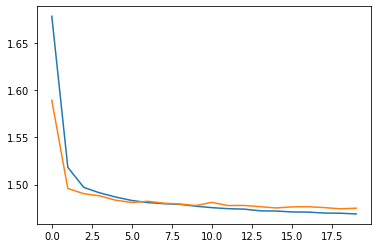

In [34]:
pyplot.plot(history[0])
pyplot.plot(history[1])
pyplot.show()

# Recap:
- Use `Dataset` --> `DataLoader` for batching
- helper functions: fit, accuracy can be re-used for other problems as well
- model.train() and model.eval() to make sure batchnorm and dropout works correctly.
- add data to gpu should be performed for all train-dev-test.
- be aware of format for parameters in `nn.CrossEntropyLoss()`

Problems not addressed:
- What if images come in different shape? Assuming that we need to massage them before the forward pass, where we should do it? Using a Lambda layer or `preprocess` function is both ok I think.